# Scanning separations and orientations

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({"font.size" : 22})

In [2]:
def read_xyz(file_name = ""):
    angstrom_to_bohr = 1.88973

    if file_name == "":
        lines = list(open("../monomer_xyzs/trunc_bchla_1_frame_1.xyz"))
    else:
        lines = list(open("added_noise.xyz"))
    
    symbols = [] 
    coords = []
    
    lines = lines[2:]

    for line in lines:
        symbol = re.findall(r'[a-zA-Z]+', line)
        coord  = np.array([float(y) * angstrom_to_bohr for y in re.findall(r'-?\d+.\d+', line)])
            
        if len(symbol) == 0 or len(coord) == 0:
            continue
                
        symbols.append(symbol[0])
        coords.append(coord)
    
    return symbols, coords

In [3]:
def get_angle(vec1, vec2):
    num = np.dot(vec1, vec2)
    dom = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    
    angle = np.rad2deg(np.arccos(num/dom))
    
    return angle

angstrom_to_bohr = 1.88973
Na_index = 14
Nb_index = 5
Nc_index = 31
Nd_index = 23

symbols, coords = read_xyz()
Na_Nc = coords[Na_index] - coords[Nc_index]
Nb_Nd = coords[Nb_index] - coords[Nd_index]

Qy_Qx_angle = get_angle(Na_Nc, Nb_Nd)

normal_to_porphyrin_plane = np.cross(Na_Nc, Nb_Nd)

unit_normal = normal_to_porphyrin_plane / np.linalg.norm(normal_to_porphyrin_plane)


## Scan distances

In [4]:
angstrom_to_bohr = 1.88973

def write_separation_files():
    symbols, coords = read_xyz()
    
    origin_coords = [x - coords[0] for x in coords]
    _, noise_coords = read_xyz("added_noise.xyz")
    
    full_scan = open(f"sep_xyzs/full_scan.xyz", 'w')
    
    
    for sep in np.linspace(15, 100, 17):
        dimer_file = open(f"sep_xyzs/dimer_sep_{int(sep)}.xyz", 'w')
        origin_monomer = open(f"sep_xyzs/origin.xyz", 'w')
        moved_monomer = open(f"sep_xyzs/monomer_sep_{int(sep)}.xyz", 'w')
        
        moved_coords = [x+unit_normal * sep for x in noise_coords]

        print(f"{79*2}", file=dimer_file)
        print(f"{79*2}", file=full_scan)
        print(f"{79}", file=origin_monomer)
        print(f"{79}", file=moved_monomer)
        
        print("", file=dimer_file)
        print("", file=full_scan)
        print("", file=origin_monomer)
        print("", file=moved_monomer)

        for enum, c in enumerate(origin_coords):
            print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=dimer_file)
            print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=full_scan)
            print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=origin_monomer)

        for enum, c in enumerate(moved_coords):
            print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=dimer_file)
            print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=full_scan)
            print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=moved_monomer)
            
            
        
        dimer_file.close()
        origin_monomer.close()
        moved_monomer.close()
    
    full_scan.close()

## Scan angles

In [5]:
def rotation_matrix(normal, angle):
    cos = np.cos(angle)
    sin = np.sin(angle)
    
    cross_product_matrix = np.array([
                                    [ 0,         -normal[2],  normal[1]],
                                    [ normal[2],  0,         -normal[0]],
                                    [-normal[1],  normal[0],  0        ]
                                   ])
    
    outer_product = np.outer(normal, normal)
    
    identity = np.identity(3)
    
    R = cos * identity + sin * cross_product_matrix + (1-cos) * outer_product
    
    return R

def write_angle_files():
    symbols, coords = read_xyz()
    _, noise_coords = read_xyz("added_noise.xyz")
    
    origin_coords = [x - coords[0] for x in coords]
    
    for sep in [15, 17, 20, 25, 30, 60]:
        full_scan = open(f"angle_xyzs/full_scan_sep_{sep}.xyz", 'w')
        
        for theta in np.linspace(0, 2*np.pi, 100):
            dimer_file = open(f"angle_xyzs/sep_{sep}_dimer_angle_{int(np.rad2deg(theta))}.xyz", 'w')
            origin_monomer = open(f"angle_xyzs/origin.xyz", 'w')
            moved_monomer = open(f"angle_xyzs/sep_{sep}_monomer_angle_{int(np.rad2deg(theta))}.xyz", 'w')

            rotation = rotation_matrix(unit_normal, theta)

            moved_coords = [np.dot(rotation, (x+(unit_normal*sep))) for x in noise_coords]

            print(f"{79*2}", file=dimer_file)
            print(f"{79*2}", file=full_scan)
            print(f"{79}", file=origin_monomer)
            print(f"{79}", file=moved_monomer)

            print("", file=dimer_file)
            print("", file=full_scan)
            print("", file=origin_monomer)
            print("", file=moved_monomer)

            for enum, c in enumerate(coords):
                print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=dimer_file)
                print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=full_scan)
                print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=origin_monomer)

            for enum, c in enumerate(moved_coords):
                print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=dimer_file)
                print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=full_scan)
                print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=moved_monomer)
            
            dimer_file.close()
            origin_monomer.close()
            moved_monomer.close()
            
        full_scan.close()


In [6]:
#write_separation_files()
#write_angle_files()

In [6]:
import os
import sys
import importlib 

sys.path.insert(0, '..')
import read_Bchla_xTB
importlib.reload(read_Bchla_xTB)
import read_tddft
importlib.reload(read_tddft)
import read_gaussian
importlib.reload(read_gaussian)
import make_json
importlib.reload(make_json)
import data_objects
importlib.reload(data_objects)
import frenkel_hamiltonians
importlib.reload(frenkel_hamiltonians)

import matplotlib
matplotlib.rcParams.update({"font.size" : 22})


In [7]:
def get_Bchla_xTB_angle_results(separation):
    angles = []
    monomer_states = [[],[]]
    dimer_states = [[], [], [], [], []]
    dimer_norms = [[], [], [], []]
    frenkel_dipole_states = [[], [], []]
    frenkel_charge_states = [[], [], []]
    frenkel_no_coupling_states = [[], [], []]

    origin_result = read_Bchla_xTB.read_monomer_Bchla_xTB_file(f"AngleScans/Bchla_xTB/Bchla_origin.out")
    origin_structure = data_objects.Structure("", "", given_file_name=f"angle_xyzs/origin.xyz")

    for theta in np.linspace(0, 2*np.pi, 100):
        dimer_result = read_Bchla_xTB.read_dimer_Bchla_xTB_file(f"AngleScans/Bchla_xTB/Bchla_sep_{separation}_dimer_angle_{int(np.rad2deg(theta))}.out")
        
        monomer_result = read_Bchla_xTB.read_monomer_Bchla_xTB_file(f"AngleScans/Bchla_xTB/Bchla_sep_{separation}_monomer_angle_{int(np.rad2deg(theta))}.out")
        monomer_structure = data_objects.Structure("", "", given_file_name=f"angle_xyzs/sep_{separation}_monomer_angle_{int(np.rad2deg(theta))}.xyz")
        
        frenkel_dipole_result = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "dipole", state=True)
        frenkel_charge_result = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "mulliken", state=True)
                        
        frenkel_no_coupling = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "off", state=True)
            
        angles.append(np.rad2deg(theta))
        
        for enum, i in enumerate(frenkel_dipole_result.eigvals):
            frenkel_dipole_states[enum].append(i)
        
        for enum, i in enumerate(frenkel_charge_result.eigvals):
            frenkel_charge_states[enum].append(i)
            
        for enum, i in enumerate(frenkel_no_coupling.eigvals):
            frenkel_no_coupling_states[enum].append(i)
        
        dimer_states[0].append(dimer_result.total_energy)
            
        for enum, i in enumerate(dimer_result.state_energies):
            norm = np.linalg.norm(dimer_result.transition_dipoles[enum])
            dimer_states[enum+1].append(i)
            dimer_norms[enum].append(norm)
            
        monomer_sum = origin_result.total_energy + monomer_result.total_energy
        
        monomer_states[0].append(monomer_sum + origin_result.transition_energy)
        monomer_states[1].append(monomer_sum + monomer_result.transition_energy)

    return {"angles" : angles,
            "dimer_states" : dimer_states,
            "monomer_states" : monomer_states,
            "dimer_norms" : dimer_norms,
            "frenkel_dipole_states" : frenkel_dipole_states,
            "frenkel_charge_states" : frenkel_charge_states,
            "frenkel_no_coupling" : frenkel_no_coupling_states}

def get_TDDFT_angle_results(method, separation):
    angles = []
    dimer_states = [[] for x in range(4)]
    dimer_transition_mags = [[] for x in range(3)]
    dimer_transition_angles = [[] for x in range(3)]
    
    frenkel_dipole_states = [[], [], []]
    frenkel_mulliken_states = [[], [], []]
    frenkel_lowdin_states = [[], [], []]
    
    origin_result = read_tddft.read_monomer_TDDFT_file(f"AngleScans/HF/HF_origin.out")
    origin_structure = data_objects.Structure("", "", given_file_name=f"angle_xyzs/origin.xyz")
    
    for theta in np.linspace(0, 2*np.pi, 100):
        try:
            dimer_result = read_tddft.read_dimer_TDDFT_file(f"AngleScans/HF/HF_sep_{separation}_dimer_angle_{int(np.rad2deg(theta))}.out")

            if dimer_result.total_energy == 0.:
                raise
            
            monomer_result = read_tddft.read_monomer_TDDFT_file(f"AngleScans/HF/HF_sep_{separation}_monomer_angle_{int(np.rad2deg(theta))}.out")
            monomer_structure = data_objects.Structure("", "", given_file_name=f"angle_xyzs/sep_{separation}_monomer_angle_{int(np.rad2deg(theta))}.xyz")

            frenkel_dipole_result = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "dipole", state=True)
            frenkel_mulliken_result = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "mulliken", state=True)
            frenkel_lowdin_result = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "lowdin", state=True)

            angles.append(np.rad2deg(theta))

            for enum, i in enumerate(frenkel_dipole_result.eigvals):
                frenkel_dipole_states[enum].append(i)

            for enum, i in enumerate(frenkel_mulliken_result.eigvals):
                frenkel_mulliken_states[enum].append(i)

            for enum, i in enumerate(frenkel_lowdin_result.eigvals):
                frenkel_lowdin_states[enum].append(i)

            dimer_states[0].append(dimer_result.total_energy)

            for enum, i in enumerate(dimer_result.state_energies):
                dimer_states[enum+1].append(i)
                
        except:
            pass

            
        
    return {"angles" : angles,
            "dimer_states" : dimer_states,
            "frenkel_dipole_states" : frenkel_dipole_states,
            "frenkel_mulliken_states" : frenkel_mulliken_states,
            "frenkel_lowdin_states" : frenkel_lowdin_states}



def get_Bchla_xTB_results(scan, separation):
    if scan == "angle":
        return get_Bchla_xTB_angle_results(separation)
    
def get_TDDFT_results(method, scan, separation):
    if scan == "angle":
        return get_TDDFT_angle_results(method, separation)
    
    
def get_response_results(method, scan, separation):
    if method == "Bchla_xTB":
        return get_Bchla_xTB_results(scan, separation)
    else:
        return get_TDDFT_results(method, scan, separation)

In [8]:
Bchla_xTB_angles_15 = get_response_results("Bchla_xTB", "angle", 15)
Bchla_xTB_angles_17 = get_response_results("Bchla_xTB", "angle", 17)
Bchla_xTB_angles_20 = get_response_results("Bchla_xTB", "angle", 20)
Bchla_xTB_angles_25 = get_response_results("Bchla_xTB", "angle", 25)
Bchla_xTB_angles_30 = get_response_results("Bchla_xTB", "angle", 30)
Bchla_xTB_angles_60 = get_response_results("Bchla_xTB", "angle", 60)

In [9]:
HF_angles_15 = get_response_results("HF", "angle", 15)
HF_angles_17 = get_response_results("HF", "angle", 17)
HF_angles_20 = get_response_results("HF", "angle", 20)
HF_angles_25 = get_response_results("HF", "angle", 25)
HF_angles_30 = get_response_results("HF", "angle", 30)
HF_angles_60 = get_response_results("HF", "angle", 60)

In [10]:
def read_camb3lyp():
    angles = []
    dimer_states = [[],[],[],[],[],[]]
    
    for theta in np.linspace(0, 2*np.pi, 100):
        try:
            dimer_result = read_gaussian.read_gaussian(f"AngleScans/Gaussian/GAUSSIAN_sep_17_dimer_angle_{int(np.rad2deg(theta))}.log")
            
            if dimer_result.total_energy == 0. or len(dimer_result.state_energies) == 0:
                raise
                
            angles.append(np.rad2deg(theta))
        
            dimer_states[0].append(dimer_result.total_energy)
            dimer_states[1].append(dimer_result.state_energies[0])
            dimer_states[2].append(dimer_result.state_energies[1])
            dimer_states[3].append(dimer_result.state_energies[2])
            dimer_states[4].append(dimer_result.state_energies[3])
            dimer_states[5].append(dimer_result.state_energies[4])
            
        except:
            continue
    
    return {"angles" : angles,
            "dimer_states" : dimer_states
           }

camb3lyp_scan = read_camb3lyp()

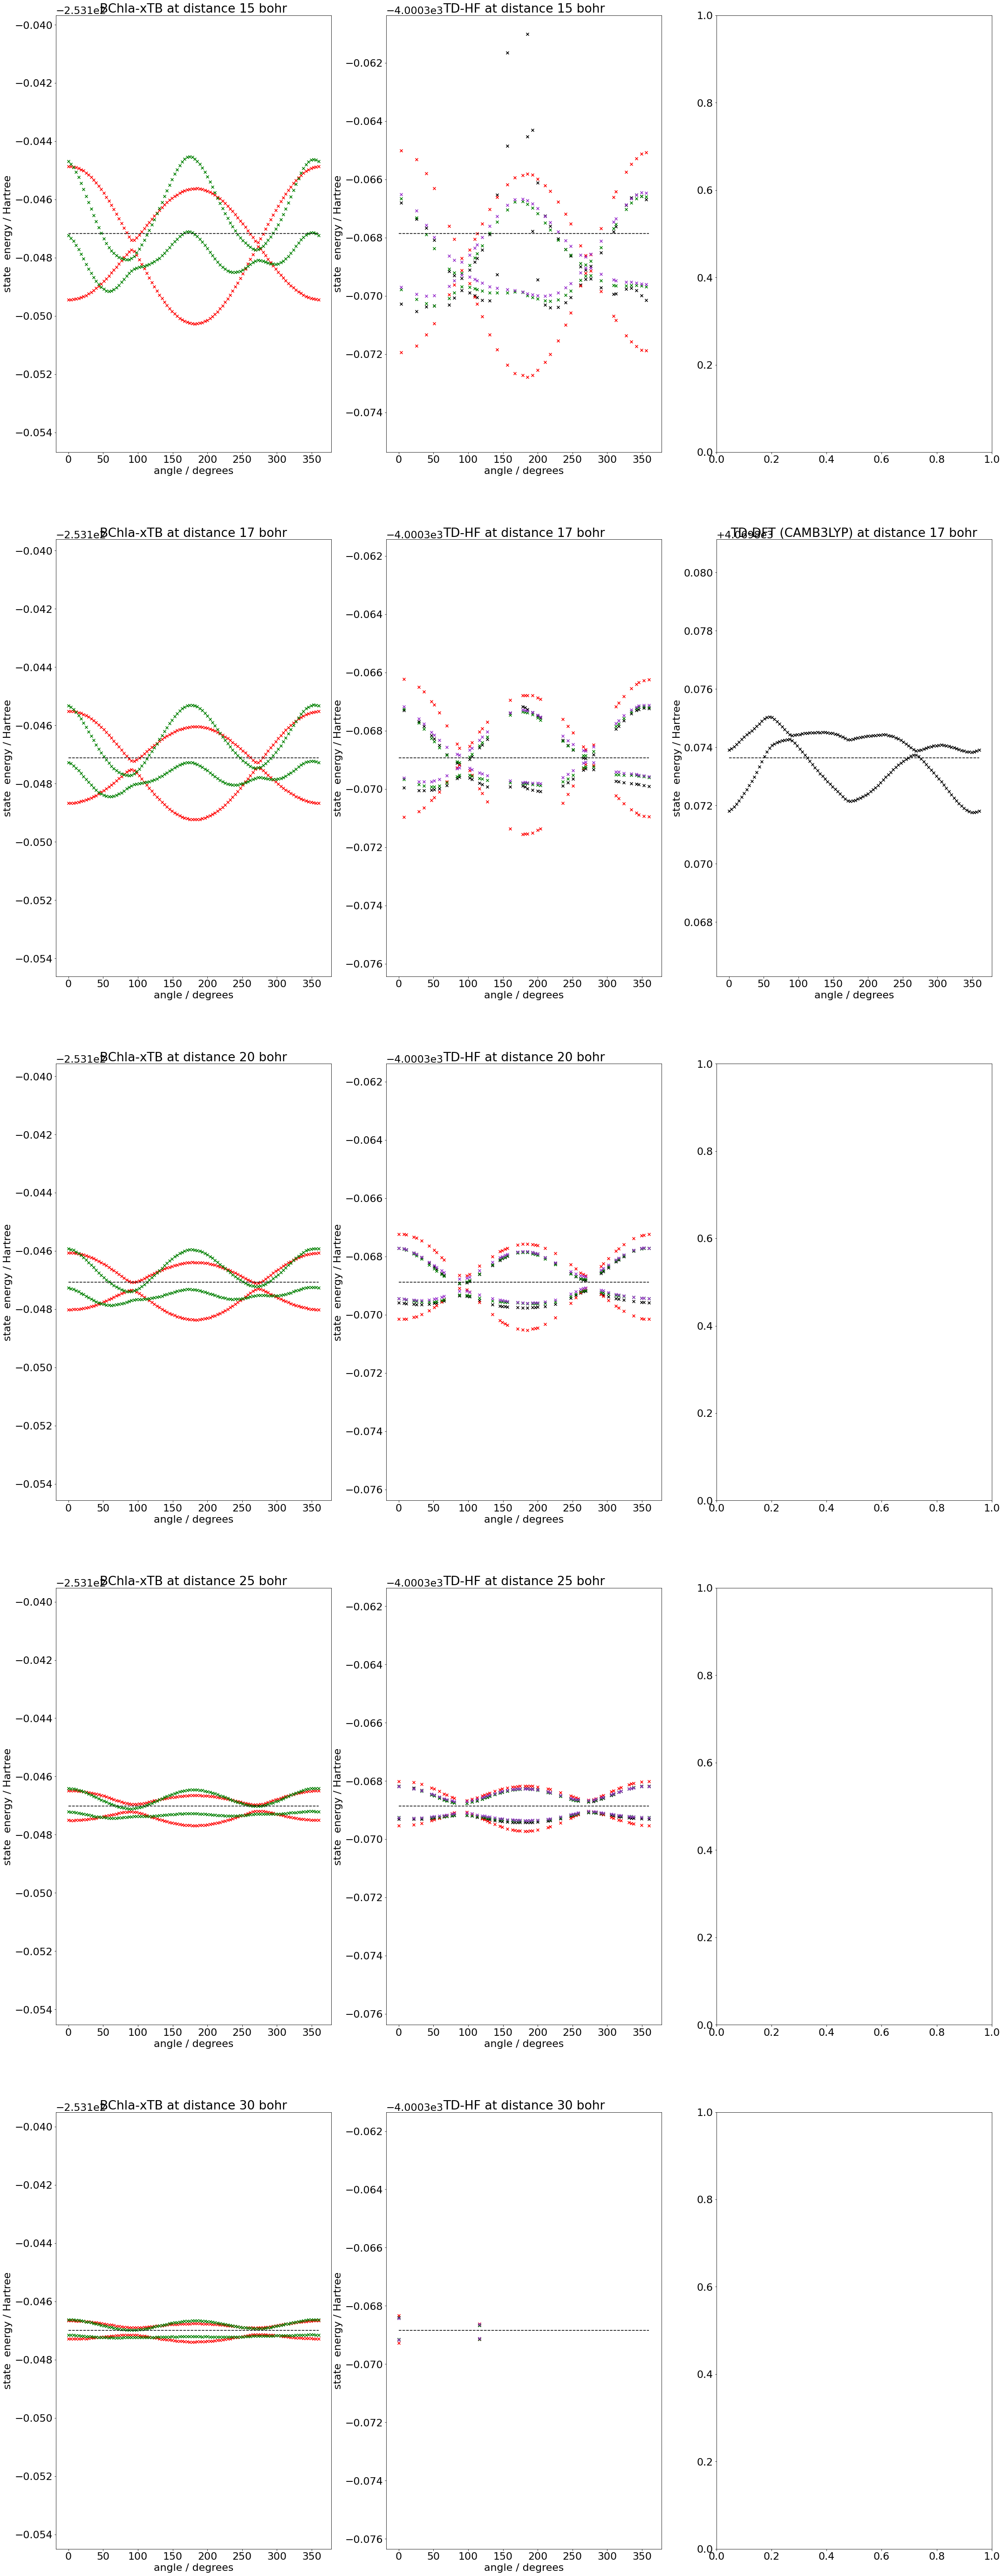

In [11]:
distances = [15, 17, 20, 25, 30]

xtb_scans = [Bchla_xTB_angles_15,
             Bchla_xTB_angles_17,
             Bchla_xTB_angles_20,
             Bchla_xTB_angles_25,
             Bchla_xTB_angles_30
            ]

HF_scans = [HF_angles_15,
            HF_angles_17,
            HF_angles_20,
            HF_angles_25,
            HF_angles_30
           ]

fig, ax = plt.subplots(5,3)

marker = 'x'

for enum, axis in enumerate(ax.ravel()):
    distance = distances[int(np.floor(enum/3))]
    
    if enum % 3 == 0:
        scan = xtb_scans[int(np.floor(enum/3))]
        axis.scatter(scan["angles"], scan["dimer_states"][0], color='black', marker=marker, label=f"dimer 1 at {distance}")
        
        #for state in scan["dimer_states"]:
        #    axis.scatter(scan["angles"], state, color='black', marker=marker, label=f"dimer states")

        average = np.mean(scan["frenkel_charge_states"][1] + scan["frenkel_charge_states"][2])
        axis.hlines([average], xmin=0, xmax=360, color='black', linestyle='--')
        
        axis.scatter(scan["angles"], scan["frenkel_dipole_states"][0], color='red', marker=marker, label=f"dipole 1")
        axis.scatter(scan["angles"], scan["frenkel_dipole_states"][1], color='red', marker=marker, label=f"dipole 2")
        axis.scatter(scan["angles"], scan["frenkel_dipole_states"][2], color='red', marker=marker, label=f"dipole 3")
        axis.scatter(scan["angles"], scan["frenkel_charge_states"][0], color='green', marker=marker, label=f"charge 1")
        axis.scatter(scan["angles"], scan["frenkel_charge_states"][1], color='green', marker=marker, label=f"charge 2")
        axis.scatter(scan["angles"], scan["frenkel_charge_states"][2], color='green', marker=marker, label=f"charge 3")
        #axis.scatter(scan["angles"], scan["frenkel_no_coupling"][0], color='blue', marker=marker, label=f"no coupling 1")
        #axis.scatter(scan["angles"], scan["frenkel_no_coupling"][1], color='blue', marker=marker, label=f"no coupling 2")
        #axis.scatter(scan["angles"], scan["frenkel_no_coupling"][2], color='blue', marker=marker, label=f"no coupling 3")


        axis.set_xlabel("angle / degrees")
        axis.set_ylabel("state  energy / Hartree")
        
        axis.set_title(f"BChla-xTB at distance {distance} bohr")

        axis.set_ylim(average - 0.0075, average + 0.0075)

    elif enum % 3 == 1:
        scan = HF_scans[int(np.floor(enum/3))]

        for enum, state in enumerate(scan["dimer_states"]):
            axis.scatter(scan["angles"], state, color='black', marker=marker, label=f"dimer states")        
        
        average = np.mean(scan["dimer_states"][1] + scan["dimer_states"][2])
        axis.hlines([average], xmin=0, xmax=360, color='black', linestyle='--')
                
        axis.scatter(scan["angles"], scan["frenkel_dipole_states"][0], color='red', marker=marker, label=f"dipole 1")
        axis.scatter(scan["angles"], scan["frenkel_dipole_states"][1], color='red', marker=marker, label=f"dipole 2")
        axis.scatter(scan["angles"], scan["frenkel_dipole_states"][2], color='red', marker=marker, label=f"dipole 3")
        axis.scatter(scan["angles"], scan["frenkel_mulliken_states"][0], color='green', marker=marker, label=f"charge 1")
        axis.scatter(scan["angles"], scan["frenkel_mulliken_states"][1], color='green', marker=marker, label=f"charge 2")
        axis.scatter(scan["angles"], scan["frenkel_mulliken_states"][2], color='green', marker=marker, label=f"charge 3")
        axis.scatter(scan["angles"], scan["frenkel_lowdin_states"][0], color='darkorchid', marker=marker, label=f"charge 1")
        axis.scatter(scan["angles"], scan["frenkel_lowdin_states"][1], color='darkorchid', marker=marker, label=f"charge 2")
        axis.scatter(scan["angles"], scan["frenkel_lowdin_states"][2], color='darkorchid', marker=marker, label=f"charge 3")

        
        axis.set_xlabel("angle / degrees")
        axis.set_ylabel("state  energy / Hartree")

        axis.set_title(f"TD-HF at distance {distance} bohr")

        axis.set_ylim(average - 0.0075, average + 0.0075)
        
    elif enum % 3 == 2:
        if enum == 5:
            #axis.scatter(camb3lyp_scan["angles"], camb3lyp_scan["dimer_states"][0], color='black', marker=marker)
            axis.scatter(camb3lyp_scan["angles"], camb3lyp_scan["dimer_states"][1], color='black', marker=marker)
            axis.scatter(camb3lyp_scan["angles"], camb3lyp_scan["dimer_states"][2], color='black', marker=marker)
            #axis.scatter(camb3lyp_scan["angles"], camb3lyp_scan["dimer_states"][3], color='black', marker=marker)
            #axis.scatter(camb3lyp_scan["angles"], camb3lyp_scan["dimer_states"][4], color='black', marker=marker)
            #axis.scatter(camb3lyp_scan["angles"], camb3lyp_scan["dimer_states"][5], color='black', marker=marker)
            
            average = np.mean(camb3lyp_scan["dimer_states"][1] + camb3lyp_scan["dimer_states"][2])
            axis.hlines([average], xmin=0, xmax=360, color='black', linestyle='--')
            
            axis.set_xlabel("angle / degrees")
            axis.set_ylabel("state  energy / Hartree")

            axis.set_title(f"TD-DFT (CAMB3LYP) at distance {distance} bohr")
            
            axis.set_ylim(average - 0.0075, average + 0.0075)



fig.set_size_inches(36, 100)

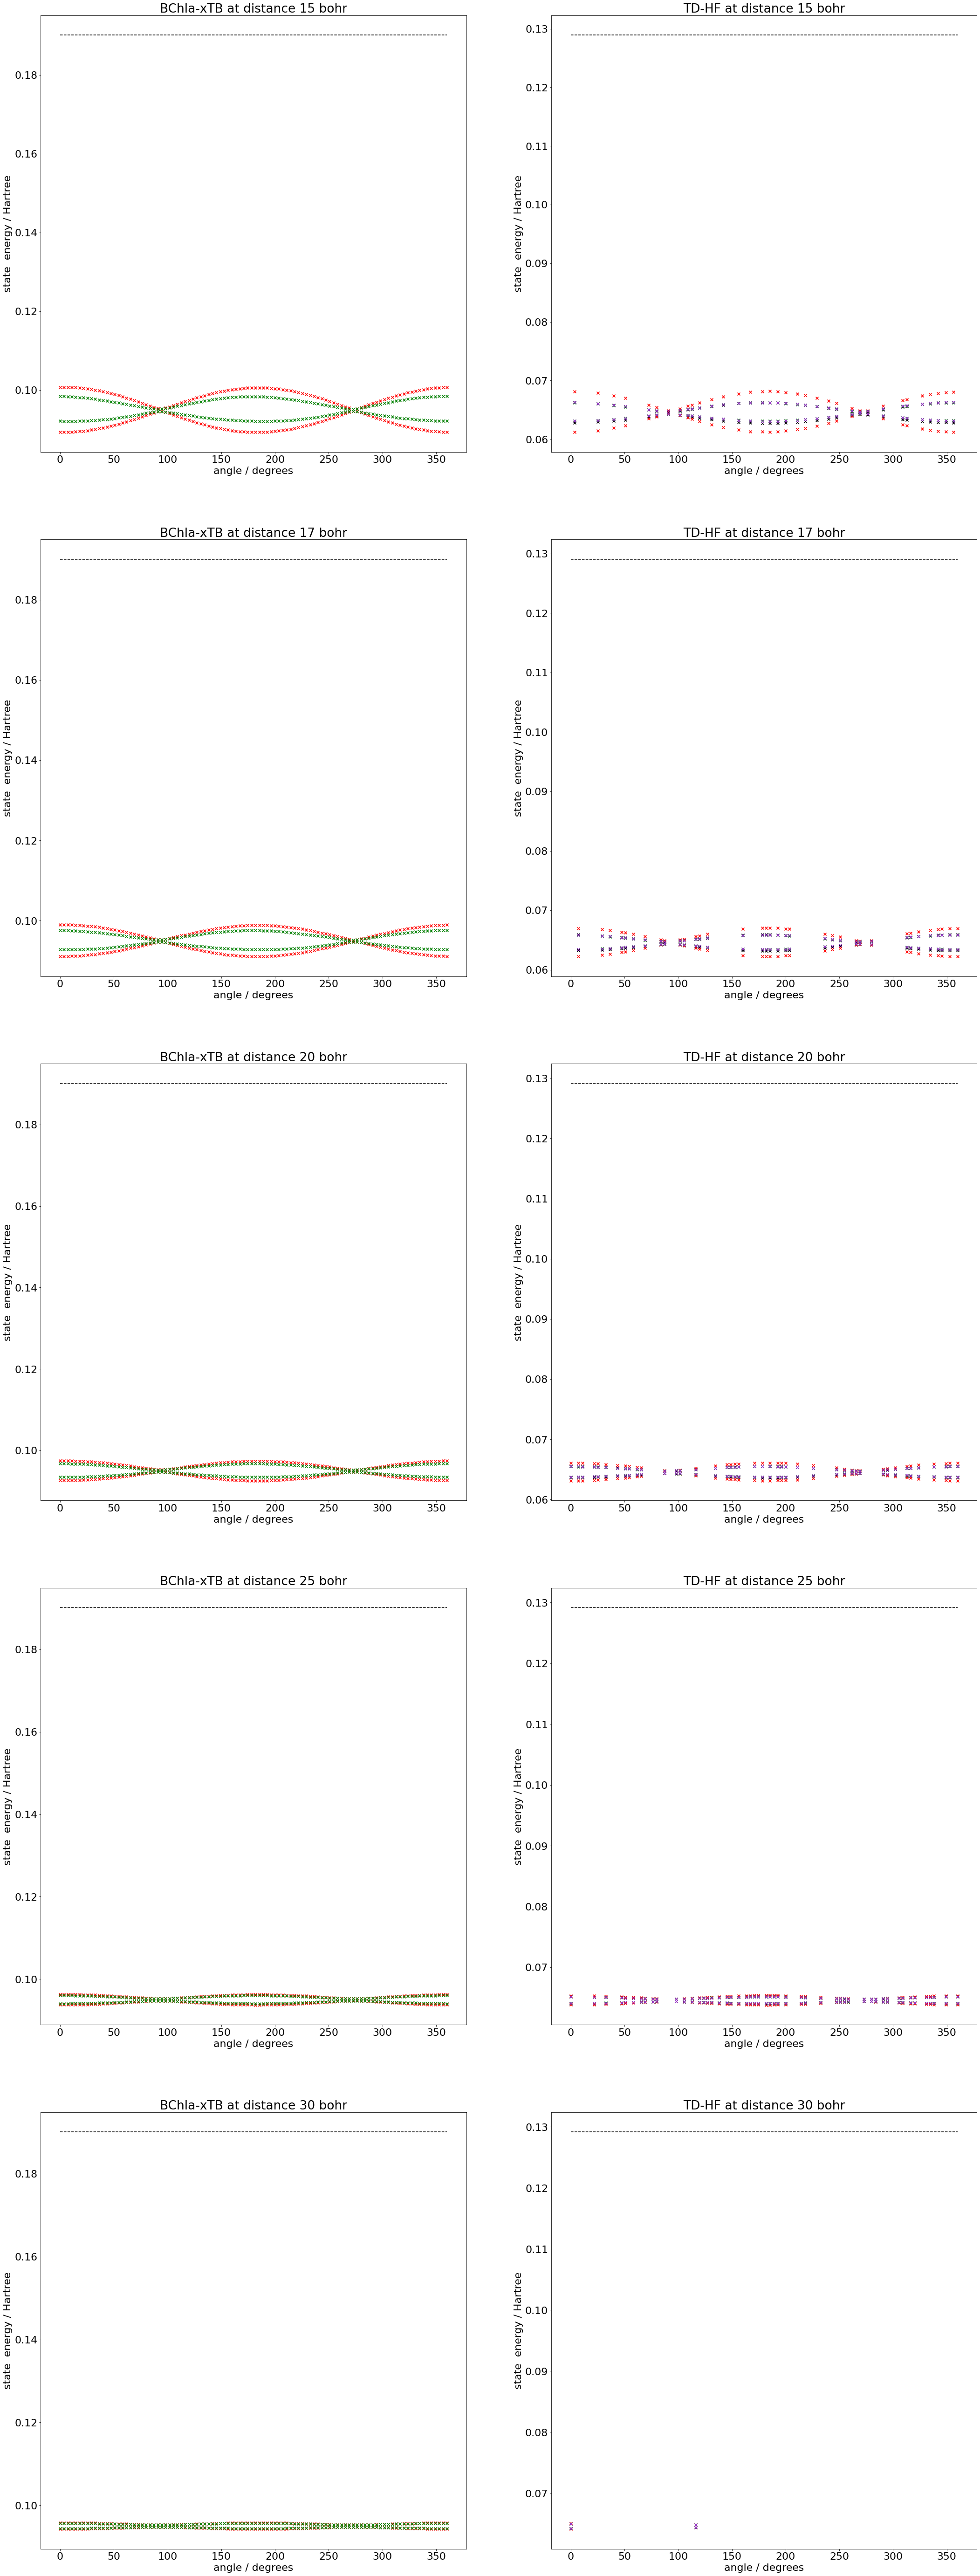

In [38]:
distances = [15, 17, 20, 25, 30, 60]

xtb_scans = [Bchla_xTB_angles_15,
             Bchla_xTB_angles_17,
             Bchla_xTB_angles_20,
             Bchla_xTB_angles_25,
             Bchla_xTB_angles_30,
            ]

HF_scans = [HF_angles_15,
            HF_angles_17,
            HF_angles_20,
            HF_angles_25,
            HF_angles_30
           ]

fig, ax = plt.subplots(5,2)

marker = 'x'

for enum, axis in enumerate(ax.ravel()):
    distance = distances[int(np.floor(enum/2))]
    
    if enum % 2 == 0:
        scan = xtb_scans[int(np.floor(enum/2))]
        
        average = np.mean((np.array(scan["frenkel_charge_states"][1])-np.array(scan["frenkel_charge_states"][0])) + (np.array(scan["frenkel_charge_states"][2])-np.array(scan["frenkel_charge_states"][0])))
        axis.hlines([average], xmin=0, xmax=360, color='black', linestyle='--')
        
        axis.scatter(scan["angles"], np.array(scan["frenkel_dipole_states"][1])-np.array(scan["frenkel_dipole_states"][0]), color='red', marker=marker, label=f"dipole 2")
        axis.scatter(scan["angles"], np.array(scan["frenkel_dipole_states"][2])-np.array(scan["frenkel_dipole_states"][0]), color='red', marker=marker, label=f"dipole 3")
        
        axis.scatter(scan["angles"], np.array(scan["frenkel_charge_states"][1])-np.array(scan["frenkel_charge_states"][0]), color='green', marker=marker, label=f"charge 2")
        axis.scatter(scan["angles"], np.array(scan["frenkel_charge_states"][2])-np.array(scan["frenkel_charge_states"][0]), color='green', marker=marker, label=f"charge 3")

        axis.set_xlabel("angle / degrees")
        axis.set_ylabel("state  energy / Hartree")
        
        axis.set_title(f"BChla-xTB at distance {distance} bohr")

        #axis.set_ylim(average - 0.0075, average + 0.0075)

    elif enum % 2 == 1:
        scan = HF_scans[int(np.floor(enum/2))]

        for enum, state in enumerate(scan["dimer_states"]):
            if enum == 0:
                continue
            if enum > 2:
                continue
                
            axis.scatter(scan["angles"], np.array(state)-np.array(scan["dimer_states"][0]), color='black', marker=marker, label=f"dimer states")        
        
        average = np.mean((np.array(scan["dimer_states"][1])-np.array(scan["dimer_states"][0])) + (np.array(scan["dimer_states"][2])-np.array(scan["dimer_states"][0])))
        
        axis.hlines([average], xmin=0, xmax=360, color='black', linestyle='--')
                
        axis.scatter(scan["angles"], np.array(scan["frenkel_dipole_states"][1])-np.array(scan["frenkel_dipole_states"][0]), color='red', marker=marker, label=f"dipole 2")
        axis.scatter(scan["angles"], np.array(scan["frenkel_dipole_states"][2])-np.array(scan["frenkel_dipole_states"][0]), color='red', marker=marker, label=f"dipole 3")

        axis.scatter(scan["angles"], np.array(scan["frenkel_mulliken_states"][1])-np.array(scan["frenkel_mulliken_states"][0]), color='green', marker=marker, label=f"charge 2")
        axis.scatter(scan["angles"], np.array(scan["frenkel_mulliken_states"][2])-np.array(scan["frenkel_mulliken_states"][0]), color='green', marker=marker, label=f"charge 3")

        axis.scatter(scan["angles"], np.array(scan["frenkel_lowdin_states"][1])-np.array(scan["frenkel_lowdin_states"][0]), color='darkorchid', marker=marker, label=f"charge 2")
        axis.scatter(scan["angles"], np.array(scan["frenkel_lowdin_states"][2])-np.array(scan["frenkel_lowdin_states"][0]), color='darkorchid', marker=marker, label=f"charge 3")

        
        axis.set_xlabel("angle / degrees")
        axis.set_ylabel("state  energy / Hartree")

        axis.set_title(f"TD-HF at distance {distance} bohr")

        #axis.set_ylim(average - 0.0075, average + 0.0075)


fig.set_size_inches(36, 100)